# Importing libraries

Importing all the necessary libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
from scipy import stats
import math as mth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Downloading Data

In [3]:
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv', sep=',')
final_ab_new_users = pd.read_csv('final_ab_new_users_upd.csv', sep=',')
final_ab_events = pd.read_csv('final_ab_events_us.csv', sep=',')
final_ab_participants = pd.read_csv('final_ab_participants_upd.csv', sep=',')

# Describing the goals of the research 

We've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

**Purpose of the test:** testing changes related to the introduction of an improved recommendation system

**Expected result:** within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.


**Technical description**
* Test name: recommender_system_test
* Groups: А (control), B (new payment funnel)
* Launch date: 2020-12-07
* Date when they stopped taking up new users: 2020-12-21
* End date: 2021-01-01
* Audience: 15% of the new users from the EU region
* Purpose of the test: testing changes related to the introduction of an improved recommendation system
* Expected number of test participants: 6000

**Please note that based on the project description, Group А is a control group, and Group B is a new payment funnel.**

# Overview 

**the calendar of marketing events for 2020**

In [4]:
print("Rows in table -> {}".format(len(ab_project_marketing_events)))
ab_project_marketing_events.head()

Rows in table -> 14


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**all users who signed up in the online store from December 7 to 21, 2020**

In [5]:
print("Rows in table -> {}".format(len(final_ab_new_users)))
final_ab_new_users.head()

Rows in table -> 58703


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**all events of the new users within the period from December 7, 2020 to January 1, 2021**

In [6]:
print("Rows in table -> {}".format(len(final_ab_events)))
final_ab_events.head()

Rows in table -> 423761


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


**table containing test participants**

In [7]:
print("Rows in table -> {}".format(len(final_ab_participants)))
final_ab_participants

Rows in table -> 14525


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


**Perfect! We have a general idea of what it's going on and we also know what our goals are!  In the next step we will merge the tables in order to have all the information we need in one unique table. Once our data is in order, we will proceed to carry out the data pre-processing.**
<br>
**Let's get started!**

# Making a new table with the necessary information.

In [8]:
#mergin tables final_ab_new_users and final_ab_events
data = final_ab_new_users.merge(final_ab_events, how='inner', on='user_id')

In [9]:
#mergin tables data and final_ab_participants
data = data.merge(final_ab_participants, how='inner', on='user_id')

In [10]:
# Taking a quick look at our table data
print("Rows in table {} -> {}".format("data",len(data)))
data.head(2)

Rows in table data -> 102838


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test


In [11]:
#using tail() method on data table
data.tail(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
102836,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-23 15:47:23,login,NaN,B,interface_eu_test
102837,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-27 03:51:35,login,NaN,B,interface_eu_test


**Taking a closer look at the first_date column**

In [12]:
#max date in first_date column
data['first_date'].max()

'2020-12-23'

The date they stopped accepting new users is 2020-12-21. But here we see that we take new users until 2020-12-23.
We need to see how many users like these we take in these two days. Also, let's take a closer look at them, to see if there's anything fishy.

In [13]:
# filtering the data in order to see the users with the dates we want to check
after_new_users = data[data['first_date']>'2020-12-21']

In [14]:
# Taking a quick look at our table data
print("Rows in table {} -> {}".format("data",len(after_new_users)))
after_new_users.head()

Rows in table data -> 5506


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
42776,F707288B9D03E181,2020-12-22,EU,Android,2020-12-22 09:12:39,product_page,NaN,A,interface_eu_test
42777,F707288B9D03E181,2020-12-22,EU,Android,2020-12-27 17:11:53,product_page,NaN,A,interface_eu_test
42778,F707288B9D03E181,2020-12-22,EU,Android,2020-12-22 09:12:39,login,NaN,A,interface_eu_test
42779,F707288B9D03E181,2020-12-22,EU,Android,2020-12-27 17:11:50,login,NaN,A,interface_eu_test
42780,14E0233F5016718D,2020-12-22,EU,Android,2020-12-22 13:28:57,product_page,NaN,B,interface_eu_test


6117 rows! But before we get stressed let's take a closer look and these rows.<br>
Looks like these events are about users that are part of the interface_eu_test. Remember that our ab test is called recommender_system_test. <br>
Let's see the value counts for the ab_test column.

In [15]:
after_new_users.groupby('ab_test').count()

,user_id,first_date,region,device,event_dt,event_name,details,group
ab_test,,,,,,,,
interface_eu_test,5506,5506,5506,5506,5506,5506,785,5506


Cool! There is nothing to worry about. We will drop these rows while droping all rows about users that are not part of the a/b test recommender_system_test. <br>
Let's continue!

In [16]:
#min date in first_date column
data['first_date'].min()

'2020-12-07'

The Launch date is 2020-12-07! So everything it's in order.

**Taking a closer look at the event_dt column**

In [17]:
#max date in event_dt column
data['event_dt'].max()

'2020-12-30 18:28:55'

The End date (when they finished the experiment) is 2021-01-01, but the max date is 2020-12-30!  These means that data for two days is missing! We should ask some questions to the team that was in charged of these data.

In [18]:
#min date in event_dt column
data['event_dt'].min()

'2020-12-07 00:02:48'

The Launch date is 2020-12-07! So everything it's in order.

**Let's check how much days the experiment was running.**

In [19]:
#Checking how much days the experiment was supposed to run
d1 = datetime.strptime('2020-12-07', "%Y-%m-%d")
d2 = datetime.strptime('2021-01-01', "%Y-%m-%d")
abs((d2 - d1).days)

25

In [20]:
#Checking how much days the experiment runned 
max =  pd.to_datetime(data['event_dt'].max())
min =  pd.to_datetime(data['event_dt'].min())
real_experiment_duration = max - min
real_experiment_duration

Timedelta('23 days 18:26:07')

So we can say that we have data for 23 and a half days (plus minus) ! <br>
But we expected to have about 25 days of data!

**Now we will filter our table!** <br>
**1. Leaving only the rows with the test name 'recommender_system_test'**

In [21]:
# counting how much rows are we deleting
rows_we_drop_ab_test = len(data.query('ab_test != "recommender_system_test"'))
rows_we_drop_ab_test

78929

In [22]:
print('Around',rows_we_drop_ab_test*100/len(data), '% of the data will be dropped')

Around 76.75081195666971 % of the data will be dropped


In [23]:
# filtering the table
data = data[data['ab_test'] == 'recommender_system_test'].sort_values('user_id')
print("Rows in table -> {}".format(len(data)))
data.head(2)

Rows in table -> 23909


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
99595,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,B,recommender_system_test
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test


**2. Deleting rows for non-EU region audience**

In [24]:
# counting how much rows are we deleting
rows_we_drop_region = len(data.query('region != "EU"'))
rows_we_drop_region

1235

In [25]:
print('Around',rows_we_drop_region*100/len(data), '% of the data will be dropped')

Around 5.165418879919695 % of the data will be dropped


In [26]:
# filtering the table
data = data.query('region == "EU"').sort_values('user_id')
print("Rows in table -> {}".format(len(data)))
data.head(2)

Rows in table -> 22674


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
99595,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,B,recommender_system_test
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test


In [27]:
data.tail(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
52270,FFF28D02B1EACBE1,2020-12-16,EU,PC,2020-12-16 08:24:57,product_cart,NaN,B,recommender_system_test
52286,FFF28D02B1EACBE1,2020-12-16,EU,PC,2020-12-24 00:51:04,login,NaN,B,recommender_system_test


In [28]:
#cheking the number of unique ids in the data table
data['user_id'].value_counts().count()

3481

**Remember the expected number of test participants - 6000. But we have 3481 participants in our data table. What's going on?!**

# Calculating Sample Size

We saw previously that we have only  3481 participants in our data table.  <br>
In theory, to determine a winner between group A and group B, we need to wait until we have enough results to see if there is a statistically significant difference between the two. For these, we need enough data. Let's calculate the sample size for these a/b test, in order to understand if our sample sizes are big enough.

In [29]:
import statsmodels.stats.api as sms
effect_size = sms.proportion_effectsize(0.30, 0.33)

def min_group_size(effect_size, power=0.8, alpha=0.05):
    required_n = sms.NormalIndPower().solve_power(
        effect_size, 
        power=power,
        alpha=alpha
        ) 
    print('sample size:', int(required_n), 'participants in each group')
    
min_group_size(effect_size)

sample size: 3761 participants in each group


So we need 3761 participants in each group to provide the test correctly with statistical power = 0.8. Also, we could summarize that the number of participants in our test is not enough to interpret the results correctly with high power. But we'll try anyway!

# Exploring the data

## Does it need converting types?

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22674 entries, 99595 to 52286
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     22674 non-null  object 
 1   first_date  22674 non-null  object 
 2   region      22674 non-null  object 
 3   device      22674 non-null  object 
 4   event_dt    22674 non-null  object 
 5   event_name  22674 non-null  object 
 6   details     3079 non-null   float64
 7   group       22674 non-null  object 
 8   ab_test     22674 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.7+ MB


### Convert the data to the necessary types
The type of the dates values are object. Will use to_datetime() method to change the types.

In [31]:
data['event_dt'] = pd.to_datetime(data['event_dt'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22674 entries, 99595 to 52286
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     22674 non-null  object        
 1   first_date  22674 non-null  object        
 2   region      22674 non-null  object        
 3   device      22674 non-null  object        
 4   event_dt    22674 non-null  datetime64[ns]
 5   event_name  22674 non-null  object        
 6   details     3079 non-null   float64       
 7   group       22674 non-null  object        
 8   ab_test     22674 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 1.7+ MB


## Are there any missing or duplicate values? If so, what's their nature?

### Looking for duplicates

In [32]:
len(data)

22674

In [33]:
data.duplicated().value_counts()

False    22674
dtype: int64

**There are no duplicates!**

### Looking for missing values

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22674 entries, 99595 to 52286
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     22674 non-null  object        
 1   first_date  22674 non-null  object        
 2   region      22674 non-null  object        
 3   device      22674 non-null  object        
 4   event_dt    22674 non-null  datetime64[ns]
 5   event_name  22674 non-null  object        
 6   details     3079 non-null   float64       
 7   group       22674 non-null  object        
 8   ab_test     22674 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 1.7+ MB


In [35]:
data['details'].value_counts()

4.99      2302
9.99       454
99.99      269
499.99      54
Name: details, dtype: int64

Perfect, missing values in the details column. This is fine for us, there are no details like 'how much money has the customer already spent' if the event is about a login. We are good! 

# Carring out exploratory data analysis

## Studing the conversion at different funnel stages

**Using the event funnel to find the share of users that proceed from each stage to the next**

For instance, for the sequence of events A → B → C, we calculate the ratio of users at stage B to the 
number of users at stage A and the ratio of users at stage C to the number at stage B.

**First, let's make tables for the events and the number of unique user_ids that participated in each event, for each group test.**

In [36]:
funnel_by_groups=[]
for i in data.group.unique():
    group=data[data.group==i].groupby(['event_name','group'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
    display(group)
    funnel_by_groups.append(group)    

,event_name,group,user_id
0,login,B,876
2,product_page,B,493
3,purchase,B,249
1,product_cart,B,244


,event_name,group,user_id
0,login,A,2604
2,product_page,A,1685
3,purchase,A,833
1,product_cart,A,782


**There is problem! the unique user_id distribution in the events is not similar for all the group tests! <br>
Let's plot the funnel any way.**

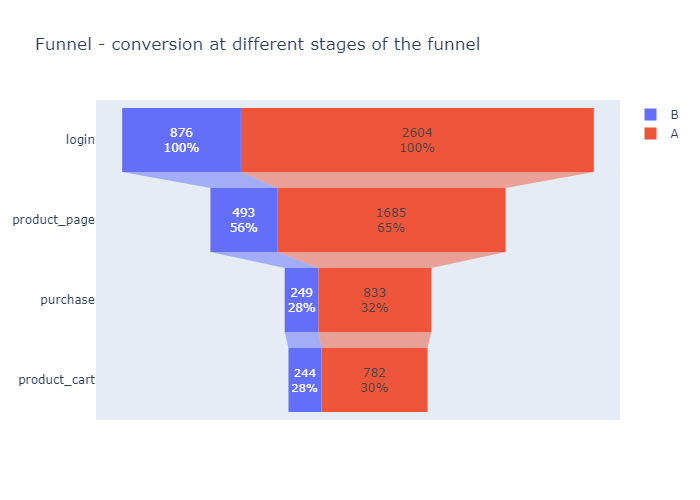

In [37]:
fig = go.Figure()  
for i in data.group.unique():
    group=data[data.group==i].groupby(['event_name','group'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
    fig.add_trace(go.Funnel( 
    name = str(group['group'].iloc[0]),
    y = group['event_name'],
    x = group['user_id'],
    textinfo = "value+percent initial"))
fig.update_layout(
    title="Funnel - conversion at different stages of the funnel")
fig.show("png")  

**What do we have?** <br>
**Remember, the expected result is: Users will show a better conversion at each stage of the product_page → product_card → purchase funnel, there will be at least a 10% increase.**

**We can see that there is a clear decrease in the percentage of users that reached each stage, while the percentages of users in group B (the users with the new payment funnel) are lower. Bad news!** <br>
**Another interesting thing is that the purchase event is before the product_car in the funnel we made, while the expected one is: login → product_page → product_card → purchase**

## Numbers of unique users that participated in 1,2,3 and 4 events

Here we see the number of unique events that each user participated in. <br>

In [38]:
users_participation_events = data.groupby(['user_id'])['event_name'].nunique().reset_index()
users_participation_events.head()

,user_id,event_name
0,001064FEAAB631A1,2
1,0010A1C096941592,3
2,00341D8401F0F665,1
3,003DF44D7589BBD4,3
4,00505E15A9D81546,1


Let's see how many users participated in the 4 events, in only 3 types of events and so on.

In [39]:
users_participation_events_f = users_participation_events.pivot_table(values='user_id', index='event_name', aggfunc='count').sort_values(by='user_id').reset_index()
users_participation_events_f.columns = ['number_of_events','number_of_users']
users_participation_events_f 

,number_of_events,number_of_users
0,4,216
1,1,696
2,3,1068
3,2,1501


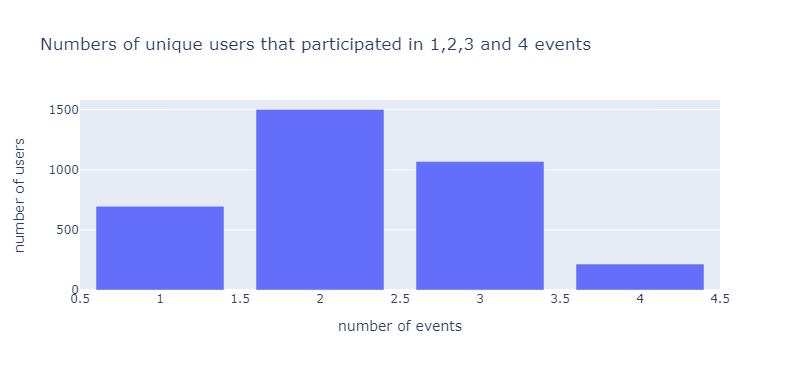

In [40]:
fig = px.bar(users_participation_events_f, y='number_of_users' , x='number_of_events',
             height=370, width=800, title='Numbers of unique users that participated in 1,2,3 and 4 events ',
              labels={
                     "number_of_users": "number of users",
                     'number_of_events' : "number of events",
                 })
fig.show("png")

**Most of users participate in 2 events. This explains everything!** <br>
**No all the users are going through the path : login → product_page → product_card → purchase.** <br>

## Looking for users with the expected path 

We are looking for users with the path :  login → product_page → product_card → purchase

In [41]:
data.head(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
99595,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,B,recommender_system_test
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test


In [42]:
users = data.pivot_table(
    index='user_id',  
    columns='event_name', 
    values='event_dt',
    aggfunc='min')

users.head(2)

event_name,login,product_cart,product_page,purchase
user_id,,,,
001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT
0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27


In [43]:
step_1 = ~users['login'].isna()
step_2 = step_1 & (users['product_page']>users['login'])
step_3 = step_2 & (users['product_cart']>users['product_page'])
step_4 = step_3 & (users['purchase']>users['product_cart'])

In [44]:
n_login = users[step_1].shape[0]
n_product_page = users[step_2].shape[0]
n_product_cart = users[step_3].shape[0]
n_purchase = users[step_4].shape[0]

In [45]:
print('Visitors:', n_login)
print('Product page:', n_product_page)
print('Product cart:',n_product_cart)
print('Purchase:', n_purchase)

Visitors: 3480
Product page: 1223
Product cart: 72
Purchase: 1


The number of users at the first stage, of course, coincides, but the following stages differ. This means that not all the users take the expected route.

## Conversion to seen-Conversion to Purchase

First, let's find a user that makes all the actions that are part of our conversion funnel. <br>
In the stage above we found that there is one user that did go through all the funnels stages.

In [46]:
users[step_4]

event_name,login,product_cart,product_page,purchase
user_id,,,,
816B178B5481C936,2020-12-08 21:06:33,2020-12-08 21:06:35,2020-12-08 21:06:34,2020-12-09 13:59:47


Let's make a function  that follows the path of our users! 

In [47]:
data.head(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
99595,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,B,recommender_system_test
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test


In [48]:
def sequence(user):
    sorted_user= data[data['user_id']==user].sort_values(by=['user_id','event_dt'])
    return sorted_user['event_name'].drop_duplicates().to_list()

Let's check that the function works correctly!

In [49]:
sequence('816B178B5481C936')

['login', 'product_page', 'product_cart', 'purchase']

Amazing! Now let's use the function on all our table!

In [50]:
sequence_empty=[]
for i in data.user_id.unique():
    sequence_empty.append([i,sequence(i)])

Let's make a data frame with what we got from the function and give names to the columns.

In [51]:
path_data=pd.DataFrame(sequence_empty,columns=['user','path'])
path_data.head()

,user,path
0,001064FEAAB631A1,"[login, product_page]"
1,0010A1C096941592,"[purchase, login, product_page]"
2,00341D8401F0F665,[login]
3,003DF44D7589BBD4,"[product_cart, product_page, login]"
4,00505E15A9D81546,[login]


The moment of truth has coming!

In [52]:
path_data['path'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[login, product_page]                            790
[login]                                          695
[product_page, login]                            224
[login, product_cart]                            197
[login, purchase, product_page]                  191
[purchase, login, product_page]                  176
[login, product_page, product_cart]              147
[login, product_cart, product_page]              141
[purchase, login]                                124
[login, purchase]                                103
[product_cart, login]                             63
[product_page, login, product_cart]               51
[product_cart, login, product_page]               51
[purchase, login, product_cart]                   43
[purchase, login, product_cart, product_page]     42
[product_page, purchase, login]                   41
[login, product_page, purchase]                   40
[login, purchase, product_cart]                   39
[product_page, login, purchase]               

**789 counts for the the path:<br>
[login, product_page]<br>**<br>

These are obviously not the results we were expected for.

While looking for paths that include the purchase event, we find him in the places 5 and 6:<br>
[purchase, login, product_page]                  194 <br>
[login, purchase, product_page]                  164 <br>

And look at this! Looks like the users first enter to the purchase page and only then proceed to login and only after login to the product page. Well, these has a easy explanation: users may see the link to purchase a product somewhere (in adds), they click at the add to purchase the product and only after they enter to the page the website ask for them to login (maybe subscribe) in order to continue, after the subscrption the website put them in the product page, in order to show them the details of the product before, and then they proceed to buy the product. <br>
In case of the second escenario (login, purchase, product_page). Users login first and then proceed to make the purchase, and after that they may continue to look at other products pages.

Remember the expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.
<br> 
Well, if we are looking for users that are following the path we are in problems!

In [53]:
# Let's see wich users follow the folowing path : product_page → product_cart → purchase
users[(users['product_cart']>users['product_page']) & (users['purchase']>users['product_cart'])]

event_name,login,product_cart,product_page,purchase
user_id,,,,
816B178B5481C936,2020-12-08 21:06:33,2020-12-08 21:06:35,2020-12-08 21:06:34,2020-12-09 13:59:47


Only one!

## ploting a simple product funnel


Well done! We could summarize that we have a simple product funnel, whereas the events do not have strong order. <br>

Also! Let's take a closer look at our last funnel:  we have the next order of the events: login - product_page - purchase - product_cart. We have correctly noted, that this order is not a logical one because in this case, the main goal of customers is viewing the product_cart, not the purchase. I guess that we should rearrange the last two events in places on the new funnel graph! <br>

In this case, we should study the absolute conversion as you have done on the plot before with the funnel, i.e.: <br>
1. login - product page
2. login - product cart
3. login - purchase

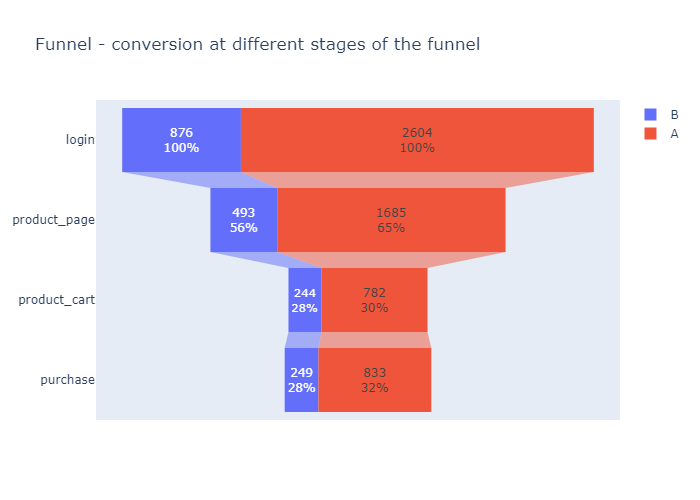

In [54]:
fig = go.Figure()  
for i in data.group.unique():
    group=data[data.group==i].groupby(['event_name','group'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
    #changinf the order of the events product_card and purchase
    group = group.reindex([0, 2, 1, 3])
    fig.add_trace(go.Funnel( 
    name = str(group['group'].iloc[0]),
    y = group['event_name'],
    x = group['user_id'],
    textinfo = "value+percent initial"))
fig.update_layout(
    title="Funnel - conversion at different stages of the funnel")
fig.show("png") 

**What do we have?** <br>
We could summarise that we have the simple product funnel because some of the events (i.e., product_cart) are not necessary to provide purchase. 

Let's describe the conversion of users from the login event into the other three events:
1. The conversion of users from login to product_page in group A is 65%, which is higher than the one in group B (56%). In this case, the new recommendation system did not increase the conversion, but, on the contrary, decrease it.
2. The conversion of users from login to product_cart in group A is 30%, which is higher than the one in group B (28%). In this case, the new recommendation system did not increase the conversion, but, on the contrary, decrease it.
3. The conversion of users from login to purchase in group A is 32%, which is higher than the one in group B (28%). In this case, the new recommendation system did not increase the conversion, but, on the contrary, decrease it.


In general, and for each of the conversion stages, the new recommendation system did not increase the conversion, but, on the contrary, decrease it.

## Time to purchase

Time to Purchase shows how long it took for visitors to the site to convert into customers. <br>
We'll use the users table we've already made, merge it with the final_ab_new_users table to get the first date of all users, and subtract the first date from the purchase date.

In [55]:
#Quick look at the users table
users.head(2)

event_name,login,product_cart,product_page,purchase
user_id,,,,
001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT
0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27


In [56]:
#mergin final_ab_new_users and users table
time_to_purchase = users.merge(final_ab_new_users, how='left', on='user_id').drop(columns= ['region','device'])
time_to_purchase.head(2)

,user_id,login,product_cart,product_page,purchase,first_date
0,001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT,2020-12-20
1,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27,2020-12-17


In [57]:
#adding a column with the time to purchase calculation
time_to_purchase['time_to_purchase'] = (pd.to_datetime(time_to_purchase['purchase']) - pd.to_datetime(time_to_purchase['first_date'])).dt.days


In [58]:
#Let's see what we got
time_to_purchase.head(2)

,user_id,login,product_cart,product_page,purchase,first_date,time_to_purchase
0,001064FEAAB631A1,2020-12-20 14:43:27,NaT,2020-12-20 14:43:28,NaT,2020-12-20,NaN
1,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27,2020-12-17,0.0


In [59]:
#time_to_purchase counts of unique values
time_to_purchase['time_to_purchase'].value_counts()

0.0    1076
1.0       5
6.0       1
Name: time_to_purchase, dtype: int64

Most of our customers place orders the first day they visit the website! <br>
Good news! No time to lose! <br>
This is also important to understand how long we should run our A/B test. It seems that two weeks should be enough! But hey! We need to make some other calculations in order to know how long should we run the A/B test.

## How Long Should We Run the A/B Test?

### Stability of Cumulative Metrics

We will analyze graphs of cumulative metrics. Said the test lasted two weeks. If you plot a graph with cumulative data, at the first-day point we'll have metric values for that day, at the second-day point you'll have the sum of metrics for the first two days, and so on. That way you can track changes in the experimental results at each day of the test. <br>
According to the central limit theorem, the values of cumulative metrics often converge and settle around a particular mean. Then a cumulative metric graph can help us decide whether to continue the test.

In [60]:
data.head(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
99595,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,B,recommender_system_test
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test


In [61]:
# building an array with unique paired date-group values 
datesGroups = data[['event_dt','group']].drop_duplicates() 
datesGroups.sample(2)

,event_dt,group
98798,2020-12-20 05:42:11,A
60401,2020-12-20 04:36:41,A


Remember, we want to check if : At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.

### conversion product_page → product_cart

**product_page**

In [62]:
data_product_page  = data.query('event_name == "product_page"')
data_product_page['event_dt'] = data_product_page['event_dt'].dt.date

<ipython-input-62-585942f1a94f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
product_page_aggregated = datesGroups.apply(lambda x: data_product_page[np.logical_and(data_product_page['event_dt'] <= x['event_dt'], data_product_page['group'] == x['group'])].agg({'event_dt' : 'max', 'group' : 'max', 'event_name' : 'count'}), axis=1).sort_values(by=['event_name','group']) 
product_page_aggregated.columns = ['date', 'group', 'counts']

C:\Users\dayab\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [64]:
product_page_aggregated.head(2)

,date,group,counts
3213,2020-12-07,A,92
8105,2020-12-07,A,92


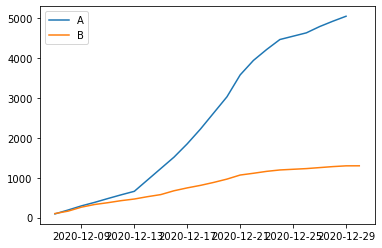

In [65]:
# DataFrame with cumulative counts for product_page by day, group A
cumulativeProductPageA = product_page_aggregated[product_page_aggregated['group']=='A']

# DataFrame with cumulative counts for product_page by day, group B
cumulativeProductPageB = product_page_aggregated[product_page_aggregated['group']=='B']

# Plotting the group A product_page event counts graph 
plt.plot(cumulativeProductPageA['date'], cumulativeProductPageA['counts'], label='A')

# Plotting the group B product_page event counts graph 
plt.plot(cumulativeProductPageB['date'], cumulativeProductPageB['counts'], label='B')

plt.legend() 

The counts for group A is rising steadily throughout the whole test. That's a good sign.<br>
Also group B, but the increase is least dramatic.

**product_cart**

In [66]:
data_product_cart  = data.query('event_name == "product_cart"')
data_product_cart['event_dt'] = data_product_cart['event_dt'].dt.date

<ipython-input-66-7a090d1f65eb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
product_cart_aggregated = datesGroups.apply(lambda x: data_product_cart[np.logical_and(data_product_cart['event_dt'] <= x['event_dt'], data_product_cart['group'] == x['group'])].agg({'event_dt' : 'max', 'group' : 'max', 'event_name' : 'count'}), axis=1).sort_values(by=['event_name','group']) 
product_cart_aggregated.columns = ['date', 'group', 'counts']
product_cart_aggregated.head(2)

C:\Users\dayab\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



,date,group,counts
3213,2020-12-07,A,35
8105,2020-12-07,A,35


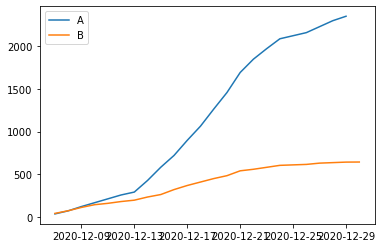

In [68]:
# DataFrame with cumulative counts for product_cart by day, group A
cumulativeProductCarA = product_cart_aggregated[product_cart_aggregated['group']=='A']

# DataFrame with cumulative counts for product_cart by day, group B
cumulativeProductCarB = product_cart_aggregated[product_cart_aggregated['group']=='B']

# Plotting the group A product_cart event counts graph 
plt.plot(cumulativeProductCarA['date'], cumulativeProductCarA['counts'], label='A')

# Plotting the group B product_cart event counts graph  
plt.plot(cumulativeProductCarB['date'], cumulativeProductCarB['counts'], label='B')

plt.legend() 

**cumulative conversion graph** <br>
**product_page → product_cart**

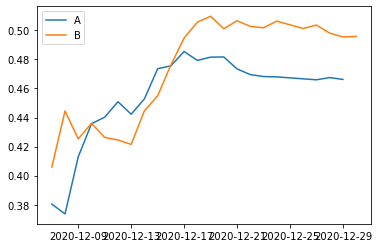

In [69]:
plt.plot(cumulativeProductPageA['date'], cumulativeProductCarA['counts']/cumulativeProductPageA['counts'], label='A')
plt.plot(cumulativeProductPageB['date'], cumulativeProductCarB['counts']/cumulativeProductPageB['counts'], label='B')
plt.legend() 

As for other observations, the groups were fluctuating around differents values, while the conversion rate of group A and B rose day by day but then stabilized. At least looks like the beginning of stability for group B.

### conversion product_cart → purchase

**purchase**

In [70]:
data_purchase  = data.query('event_name == "purchase"')
data_purchase['event_dt'] = data_purchase['event_dt'].dt.date

<ipython-input-70-962d3ee65ef9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
purchase_aggregated = datesGroups.apply(lambda x: data_purchase[np.logical_and(data_purchase['event_dt'] <= x['event_dt'], data_purchase['group'] == x['group'])].agg({'event_dt' : 'max', 'group' : 'max', 'event_name' : 'count'}), axis=1).sort_values(by=['event_name','group']) 
purchase_aggregated.columns = ['date', 'group', 'counts']
purchase_aggregated.head(2)

C:\Users\dayab\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



,date,group,counts
3213,2020-12-07,A,43
8105,2020-12-07,A,43


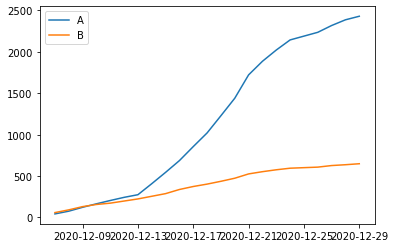

In [72]:
# DataFrame with cumulative counts for purchase by day, group A
cumulativePurchaseA = purchase_aggregated[purchase_aggregated['group']=='A']

# DataFrame with cumulative counts for purchase by day, group B
cumulativePurchaseB = purchase_aggregated[purchase_aggregated['group']=='B']

# Plotting the group A purchase event counts graph 
plt.plot(cumulativePurchaseA['date'], cumulativePurchaseA['counts'], label='A')

# Plotting the group B purchase event counts graph  
plt.plot(cumulativePurchaseB['date'], cumulativePurchaseB['counts'], label='B')

plt.legend() 

**cumulative conversion graph** <br>
**product_cart → purchase**

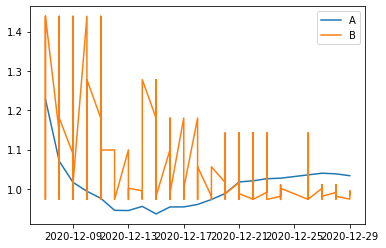

In [73]:
plt.plot(cumulativePurchaseA['date'], cumulativePurchaseA['counts']/cumulativeProductCarA['counts'], label='A')
plt.plot(cumulativePurchaseB['date'], cumulativePurchaseB['counts']/cumulativeProductCarB['counts'], label='B')
plt.legend() 

Okay! We see the conversion rate of group A dropped before stabilizing, while the conversion rate for group B fluctuats all the time! Well, we already know the sample sizes are not big enought.

The sampel size calculator say the sample size is 3761 participants in **each group**. But we have a total of only 3481 participants, while only 877 participants are from group B. 

Two weeks should be enough time to test, since the time to purchase is around a day, but we can't be sure! Because the sample sizes are not large enough and the conversion rates do not stabilize on the charts.

## Is the number of events per user distributed equally in the samples?

In [74]:
A = data.query('group == "A"').groupby(['user_id'])['event_name'].count()
B = data.query('group == "B"').groupby(['user_id'])['event_name'].count()

<AxesSubplot:>

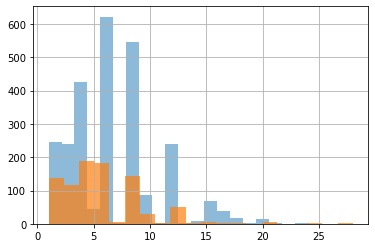

In [75]:
A.hist(bins=20, alpha=0.5)  # builds a histogram with four bins
B.hist(
    bins=20, alpha=0.7
)  # builds a histogram with nine bins, the boundaries for which are listed, where the alpha argument gives us an opaque graph 

**Maybe?** <br>
The event counts for the two groups are different (with group A leading the way in terms of number of events), but the distribution of the number of events is similar!

### average number of events per user for each group

In [76]:
A = data.query('group == "A"').groupby(['user_id'], as_index=False)['event_name'].count()
B = data.query('group == "B"').groupby(['user_id'], as_index=False)['event_name'].count()

In [77]:
#changinf the names of the columns 
A.columns = ['user_id','counts_events']
B.columns = ['user_id','counts_events']

In [78]:
A.describe()

,counts_events
count,2604.000000
mean,6.785714
std,3.733456
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [79]:
B.describe()

,counts_events
count,877.000000
mean,5.705815
std,3.455540
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,28.000000


In [80]:
A_avg = A['counts_events'].mean()
B_avg = B['counts_events'].mean()

In [81]:
print('The average number of events per user for group A is ',A_avg)
print('The average number of events per user for group B is ',B_avg)

The average number of events per user for group A is  6.785714285714286
The average number of events per user for group B is  5.70581527936146


These numbers are really close! But looks that the number tends to be higher for the group A!

## Are there users who enter both samples?

**number of unique users**

In [82]:
data['user_id'].nunique()

3481

**How much users are in each group, value_counts()**

In [83]:
data.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

**How much users are in more that one group, value_counts()**

In [84]:
data.groupby(['user_id'])['group'].nunique().value_counts()

1    3481
Name: group, dtype: int64

**No users enter both samples!**

## How is the number of events distributed by days?

In [85]:
#creating the necessary variables for further investigation : using the data table
data['day'] = data['event_dt'].dt.date

In [86]:
#per day
events_per_day = data.groupby(['day','event_name']).agg({'user_id': 'count'}).reset_index()
events_per_day.columns = ['day', 'event_name', 'counts']
display("events_per_day",events_per_day.head(6))

'events_per_day'

,day,event_name,counts
0,2020-12-07,login,303
1,2020-12-07,product_cart,76
2,2020-12-07,product_page,193
3,2020-12-07,purchase,102
4,2020-12-08,login,259
5,2020-12-08,product_cart,67


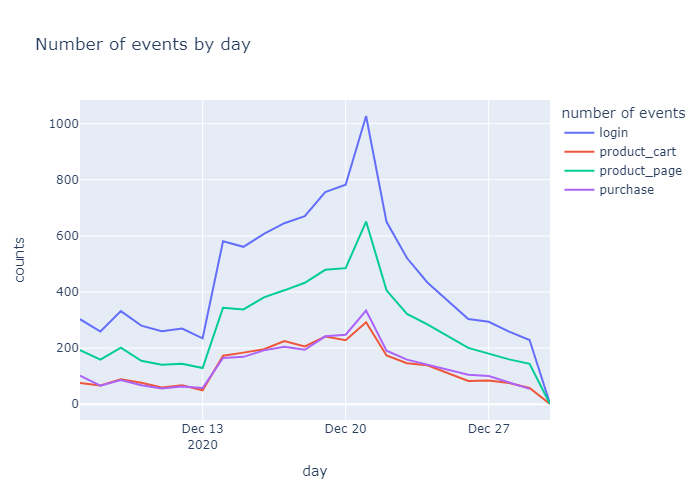

In [87]:
#number of events per day
fig = px.line(events_per_day,x="day", y="counts",title='Number of events by day', color="event_name",
              labels={
                     "day": "day",
                     "event_name": "number of events",
                 })
fig.show("png")

**What do we have?** <br>
**We see that the product_cart event leads the purchase event almost every day (as expected). But there are days when the purchase event leads. Perhaps because there are people who do not need to consult the product page, they already know that they want the product and the necessary details. Maybe our marketing strategy is so good that customers just buys!, Without checking too much.**

**Describing in detail the distribution of the events per days** <br>
* For the first 7 days the data numbers of events by day look stable. 
* Dec 14 - We see a nice positive pick! 
* Dec 15 until Dec 20 - The number of events increase day by day
* Dec 21 - Another positive pick! 
* Dec 22 until end of the experiment - The number of events decreases day by day! The number of events by day decreases and reaches the lowest levels ever.

### number of events distributed by days, per group

In [88]:
#by days, per group
events_per_day_group = data.groupby(['day','event_name','group']).agg({'user_id': 'count'}).reset_index()
events_per_day_group.columns = ['day', 'event_name', 'group', 'counts']
display("events_per_day_group",events_per_day_group.head(6))

'events_per_day_group'

,day,event_name,group,counts
0,2020-12-07,login,A,148
1,2020-12-07,login,B,155
2,2020-12-07,product_cart,A,35
3,2020-12-07,product_cart,B,41
4,2020-12-07,product_page,A,92
5,2020-12-07,product_page,B,101


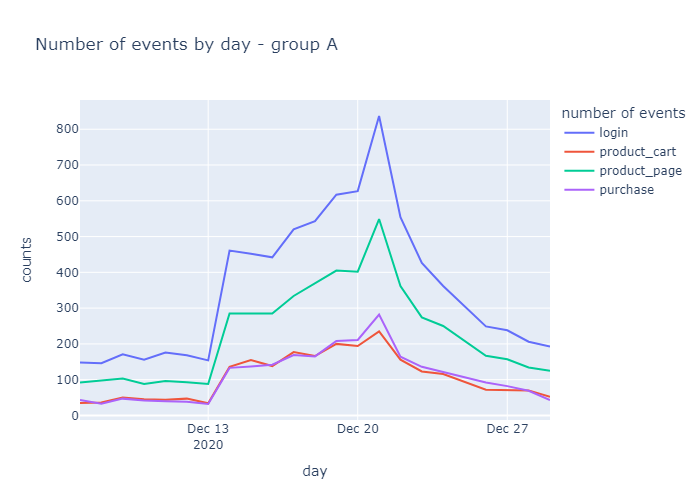

In [89]:
#number of events per day
fig = px.line(events_per_day_group.query('group == "A"'),x="day", y="counts",title='Number of events by day - group A', color="event_name",
              labels={
                     "day": "day",
                     "event_name": "number of events",
                 })
fig.show("png")

**Look at this!** <br>
Well, the distribution of the number of events by days for the group  A looks pretty much like the distribution for the two groups together. Nothing suspicious!

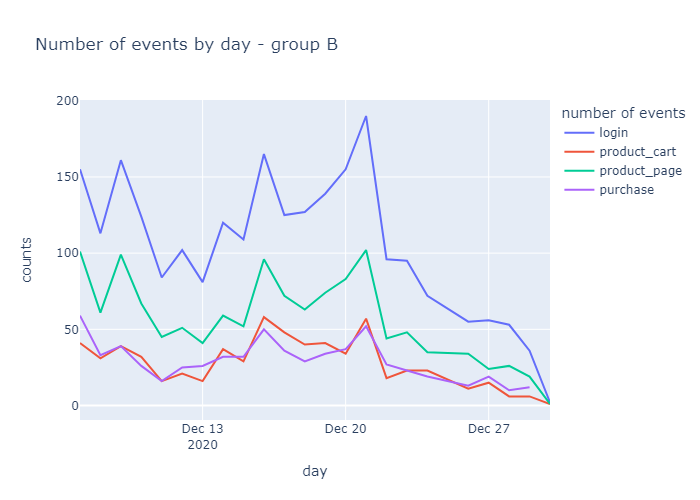

In [90]:
#number of events per day
fig = px.line(events_per_day_group.query('group == "B"'),x="day", y="counts",title='Number of events by day - group B', color="event_name",
              labels={
                     "day": "day",
                     "event_name": "number of events",
                 })
fig.show("png")

**Look at this!**<br>
Well, the distribution of the number of events by days for the group  B looks different. Interesting!

**Describing in detail the distribution of the events per days** <br>
* Dec 3 until Dec 17 - We see a lot of positives and negative spicks!
* Dec 18 until Dec 21 - The number of events increase day by day, while 21 is the day with the highest number of events ever.
* Dec 22 until end of the experiment - The number of events decreases day by day! The number of events by day decreases day by day and reaches the lowest levels ever.

### analyzing if any marketing events overlap the date range of the test

In [91]:
def is_between(event_dt,start_dt,finish_dt):   
    if start_dt <= event_dt <= finish_dt:
        return True

In [92]:
def is_between_2(event_dt,row):   
    for row in data:
        if is_between(event_dt,row['start_dt'],row['finish_dt']):
            return 'TRUE'

In [93]:
##data['is_in'] = data.apply(is_between_2, axis=1)

In [94]:
min = ab_project_marketing_events['start_dt'].min()

In [95]:
# the reviewer's code
ab_project_marketing_events.query('start_dt <= "2020-12-30" and finish_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [96]:
# the reviewer's code
data['is_in'] = data.apply(lambda x: True if \
                   (x['event_dt'] >= pd.Timestamp('2020-12-25') \
                  and x['event_dt'] <= pd.Timestamp('2021-01-03')) \
                          else False, axis = 1)

In [97]:
# the reviewer's code
range_min = ab_project_marketing_events.query('start_dt <= "2020-12-30" and \
                            finish_dt >= "2020-12-07" and \
                            regions.str.contains("EU")', engine = 'python').start_dt.min()
range_max = ab_project_marketing_events.query('start_dt <= "2020-12-30" and \
                            finish_dt >= "2020-12-07" and \
                            regions.str.contains("EU")', engine = 'python').finish_dt.min()

data['is_in'] = data.apply(lambda x: True if \
                   (x['event_dt'] >= pd.Timestamp(range_min) \
                  and x['event_dt'] <= pd.Timestamp(range_max)) \
                          else False, axis = 1)

In [98]:
#Let's see how the table looks now 
data.sample(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test,day,is_in
38717,3FA3E2FF739D5706,2020-12-15,EU,PC,2020-12-27 20:01:50,purchase,9.99,A,recommender_system_test,2020-12-27,True
10181,8025229CCC15FC7D,2020-12-07,EU,Android,2020-12-07 04:48:55,login,NaN,B,recommender_system_test,2020-12-07,False


In [99]:
#Let's check wich events overlap with marketing events
print("Rows in table -> {}".format(len(data[data['is_in']==True])))
data[data['is_in']==True].head(2)

Rows in table -> 2418


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test,day,is_in
99597,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,B,recommender_system_test,2020-12-26,True
99591,001064FEAAB631A1,2020-12-20,EU,Android,2020-12-26 15:55:18,product_page,NaN,B,recommender_system_test,2020-12-26,True


In [100]:
print('Around',len(data[data['is_in']==True])*100/len(data), '% of the events overlap with the marketing event "Christmas&New Year Promo"')

Around 10.664196877480816 % of the events overlap with the marketing event "Christmas&New Year Promo"


In [101]:
#Cheking if these users are all of them part of the group B
data[(data['is_in']==True)].groupby('group')['is_in'].count()

group
A    2019
B     399
Name: is_in, dtype: int64

In [102]:
print('Around',len(data[(data['is_in']==True) & (data['group']=='A')])*100/len(data['group']=='A'), '% of the events for group A overlap with the marketing event "Christmas&New Year Promo"')

Around 8.904472082561524 % of the events for group A overlap with the marketing event "Christmas&New Year Promo"


In [103]:
print('Around',len(data[(data['is_in']==True) & (data['group']=='B')])*100/len(data['group']=='B'), '% of the events for group B overlap with the marketing event "Christmas&New Year Promo"')

Around 1.759724794919291 % of the events for group B overlap with the marketing event "Christmas&New Year Promo"


This explains a lot of things! <br>
We can see that 11% percent of the events for group A occur between 2020-12-25 and 2021-01-03, so they were affected by the marketing event "Christmas&New Year Promo", and for these reason we see a nice positive pick at Dec 14! And of course, we see in general a rise in events after these date, something we don't fo real see for group B.

## Thinking on the possible details in the data that we have to take into account before starting the A/B test

The test procedure, called the two-proportion z-test, is appropriate when the following conditions are met:
1. The samples are independent, and they are!
2. Each sample includes at least 10 successes and 10 failures, and this is right in our case!.
3. Each population is at least 20 times as big as its sample. And here we are not sure if we are okay. We know that the audience is 15% of the new users from the EU region. So if our population is all the new users for the EU region we are in problems, but! If our population is ALL the users from EU region we are okay!


About the samples's size! We used a samples size calculator and we saw that the number of participants in our test is not enough to interpret the results correctly with high power. But we'll try anyway!

# Evaluating the A/B test results

## What can you tell about the A/A test results?
Or about whether we can run an A/A test or not?

Well, based on the projectdescription, we should not run the A/A test.

However, we could run the A/A test here because we have more users within Group A rather than Group B.

**doing sampling from group A , creating 2 A groups**

In [104]:
# the reviewer's code:

# make the data sets with unique users:
uniq_users_A = data.query('group == "A"')[['user_id']].drop_duplicates()

# let's check their number:
display(len(uniq_users_A))

# let's separate the users by 50/50:
group_A1 = uniq_users_A.sample(frac=0.5, random_state=200)
group_A2 = uniq_users_A.drop(group_A1.index)

# let's check the results:
display(len(group_A1))
display(len(group_A2))

# after that prepare the whole datasets for these groups:
group_A1 = group_A1.merge(data, on = 'user_id', how = 'inner')
group_A2 = group_A2.merge(data, on = 'user_id', how = 'inner')

# let's check the results:
display(group_A1.user_id.nunique())
display(group_A2.user_id.nunique())

# after that we could make common dataset

2604

1302

1302

1302

1302

In [105]:
# the reviewer's code:

# also we could use this approach:
test = data.copy() 
group_A1 = data.query('group == "A"')[['user_id']].drop_duplicates().sample(frac=0.5, random_state=200)

def AAB_test_group(row):
    if row['user_id'] in group_A1.user_id.unique():
        return "A2"
    return row['group']

test['AAB_group']  = test.apply(AAB_test_group, axis = 1)

In [106]:
# let's check:
test_group = test.groupby('AAB_group').agg({'user_id' : 'nunique'}).reset_index()

test_group_events = test.pivot_table(columns = 'AAB_group', values='user_id', index='event_name',aggfunc=pd.Series.nunique).reset_index()

display(test_group)
display(test_group_events)

,AAB_group,user_id
0,A,1302
1,A2,1302
2,B,877


AAB_group,event_name,A,A2,B
0,login,1302,1302,876
1,product_cart,397,385,244
2,product_page,843,842,493
3,purchase,418,415,249


**In general:** <br>
**What are we actually checking? Whether there is a statistical difference in conversion aka proportion. For example: "Is the share of users (from all users in the test) that had "product_cart event of one control group is statistically different from another?"**


**Formulating the null and alternative hypothesis:**<br>
**H0: The proportions of sample1 and sample2 samples are equal.**<br>
**H1: The proportions of sample1 and sample2 samples are not equal.**

**Testing the hypothesis that proportions of sample1 and sample2 samples are equal:**<br>
**Python doesn't have a standard test for this, so we'll write one ourselves.**

**successes : the number of events - event_nums**<br>
**Knowing the event name and the name of the group, we can access any value of success from our pivot table for any event.**<br>

**trials : the number of users in the group - users_nums<br>
Keep in mind that value of trials will always be the same - the number of users in the groups.<br>
We will take the values from the table we made in the previous question : test_group.**

In general, we will provide eight tests, so we should use the correction as 0.05/8. However,  the A/A is not necessary based on the project description and we are doing it fun, so that we could provide only for tests for the A and A2 groups.

**Building the function - z_test**

In [107]:
def z_test(event_name, trials, successes):
    alpha = .05 # significance level
    alpha = alpha/4 # significance level after correction
    
    print(event_name)

    # success proportion in the first group:
    p1 = successes[0]/trials[0]

    # success proportion in the second group:
    p2 = successes[1]/trials[1]

    # success proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # the difference between the datasets' proportions
    difference = p1 - p2 
    
    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)   
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    
    print(successes[0],successes[1],trials[0],trials[1])
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different") 
    print('-' * 100)

### A/A testing 

Now, it's the moment to use our function and check the null hypothesis. <br>
We are running first a A/A test, so we are checking if the proportions between groups A and A2 are equals.

**Formulating the null and alternative hypothesis**<br>
H0: The proportions of A and A2 are equal.<br>
H1: The proportions of A and A2 are not equal.<br>

**trials -  the number of unique users by group**

In [108]:
#taking a look at the table test_group
test_group

,AAB_group,user_id
0,A,1302
1,A2,1302
2,B,877


In [109]:
#making 2 variables, for the number of unique users for each group/ trials
trials_A = test_group[test_group['AAB_group']=='A']['user_id'].to_list()
trials_A2 = test_group[test_group['AAB_group']=='A2']['user_id'].to_list()
trials_B = test_group[test_group['AAB_group']=='B']['user_id'].to_list()

**successes : the number of events by group** <br>
We are Using iloc method to get the number of events by group using the index for columns and rows. Use the table to know the index of the columns and rows we need.

In [110]:
test_group_events

AAB_group,event_name,A,A2,B
0,login,1302,1302,876
1,product_cart,397,385,244
2,product_page,843,842,493
3,purchase,418,415,249


In [111]:
#running the Z test for samples A and A2!
for i in range(len(test_group_events)):
    event_name = test_group_events.iloc[i,0]
    trials = [trials_A[0], trials_A2[0]]
    successes = [test_group_events.iloc[i,1], test_group_events.iloc[i,2]]
    z_test(event_name, trials, successes)    

login
1302 1302 1302 1302
p-value:  nan
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------
product_cart
397 385 1302 1302
p-value:  0.6079456953236051
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------
product_page
843 842 1302 1302
p-value:  0.9672899552924821
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------
purchase
418 415 1302 1302
p-value:  0.899699901200381
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------


<ipython-input-107-665243fef43d>:20: RuntimeWarning:

invalid value encountered in double_scalars



**What do we have?** <br>
There is not reason to consider the proportions different. These means our A/A test gone good! Perfect!, we can continue with our A/B testing!

## Use the z-criterion to check the statistical difference between the proportions

**Yes, we are talking about doing an A/B test!<br>
How are we doing the test? Using the function we just made!**<br>

**What do we want to analyze?**<br>
* Equality of proportions of populations - A and B

**Formulating the null and alternative hypothesis:**<br>
**H0: The proportions of A and B are equal.**<br>
**H1: The proportions of A and B are not equal.**

In general, we have provided the eight tests, so we should use the correction as 0.05/8. However, the A/A was not necessary based on the project description and we did it for fun, so that we could provide only for tests for the A and B groups.

In [112]:
# let's make the tables we need!
test_group_ab = data.groupby('group').agg({'user_id' : 'nunique'}).reset_index()

test_group_events_ab = data.pivot_table(columns = 'group', values='user_id', index='event_name',aggfunc=pd.Series.nunique).reset_index()

display(test_group_ab)
display(test_group_events_ab)

,group,user_id
0,A,2604
1,B,877


group,event_name,A,B
0,login,2604,876
1,product_cart,782,244
2,product_page,1685,493
3,purchase,833,249


In [113]:
#making 2 variables, for the number of unique users for each group/ trials
trials_A = test_group_ab[test_group_ab['group']=='A']['user_id'].to_list()
trials_B = test_group_ab[test_group_ab['group']=='B']['user_id'].to_list()

In [114]:
#running the Z test for A A and B!
for i in range(len(test_group_events_ab)):
    event_name = test_group_events_ab.iloc[i,0]
    trials = [trials_A[0],trials_B[0]]
    successes = [test_group_events_ab.iloc[i,1], test_group_events_ab.iloc[i,2]]
    z_test(event_name, trials, successes)   

login
2604 876 2604 877
p-value:  0.08481837035887363
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------
product_cart
782 244 2604 877
p-value:  0.21469192029582396
Failed to reject the null hypothesis: there is no reason to consider the proportions different
----------------------------------------------------------------------------------------------------
product_page
1685 493 2604 877
p-value:  6.942739359416805e-06
Rejecting the null hypothesis: there is a significant difference between the proportions
----------------------------------------------------------------------------------------------------
purchase
833 249 2604 877
p-value:  0.04652482738393027
Failed to reject the null hypothesis: there is no reason to consider the proportions different
------------------------------------------------------------------------------------------

**What do we have?** <br>
There is not reason to consider the proportions different for almost all the convertion stages. There is a stadistical difference in the proportions only for the product_page stage, but we already know that this stage is not so relevant for our funnel. These means the changes we made did not affect the customer behavior!

# The Big Picture Thus Far

The expected result was that users will show better conversion into product page views (the product_page event), product card views (product_card) and purchases (purchase). At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% decrease. After running the A/B test we can conclude that a better conversion was not recorded and the result was not as expected. Any way, we must remember the samples sizes are not big enough! There is no way to make a good conclusion 